In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from astropy.constants import M_sun, G
import astropy.units as u
import os
top = os.getenv('HOME')+'/codes/dispatch2/'
os.chdir(top+'experiments/ISM/python')
import tqdm
from lmfit import Model
#from scipy import stats

import sys
sys.path.insert(0,top+'utilities/python')
import dispatch as dis
import dispatch.select as dse
import dispatch.graphics as dgr
import dispatch.particles as dpa

sys.path.append('my_funcs/')
from plot_funcs import plot_density, plot_velocity
from old_calcfuncs import calc_mean_angvec, dist, calc_meanL, patch_diag

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

# Calculating the disk scaleheight 

## There are 2 ways of calculating the scale height: the easy and the ambitious.
### 1. The disk is flat and the scale height is simply:
### $$\frac{H_p}{r}=\frac{c_s^{iso}}{\Omega_K}$$
### $$\langle c_s \rangle = \frac{P}{\rho}$$ 
### 2. One can also make a fit from the the densities in $r +\Delta r$ cylindrical rings to the function below
### $$\rho(r,z)=\frac{\Sigma_g(r)}{\sqrt{2\pi}H_p}  \exp{(-z^2/2H_p^2)}$$ (Armitage p. 71)
### $$\Rightarrow \ln(\rho)(r,z)=const - \frac{z^2}{2H_p^2}$$

In [2]:
# Create directory containing the snapshots
snaps = {}
i_snap = 710; f_snap = 710 + 1
for io in range(i_snap, f_snap):
    sn = dis.snapshot(io,'my_core_13restart')
    cgs_time = sn.scaling.t / sn.cgs.yr
    snaps[io] = sn
    print(io, f'{sn.time * cgs_time:3.0f} yr')

710 21212 yr


In [3]:
L_100 = calc_meanL(sn, angle_to_calc = np.array([1, 0, 0]), distance=100) #Average over cells

Angle between the given vector and the mean angular momentum vector: 20.1 deg


#### Now just look at one particular part of the disk

In [4]:
e_z = L_100
star_pos = sn.sinks[13][0].position
cgs_length = sn.scaling.l / sn.cgs.au
cgs_density = sn.scaling.d / 0.001; print(cgs_density)

densities = []
heights = []
for p in sn.patches:
    r = p.position - star_pos
    z_new = np.dot(r, e_z)
    r_new = r - z_new * e_z
    radius = 10 / cgs_length
    Δ_radius = 1 / cgs_length
    if abs(z_new) <= 2*radius and np.linalg.norm(r_new) < radius + Δ_radius and np.linalg.norm(r_new) > radius - Δ_radius:

        e_r = r_new / np.linalg.norm(r_new)
        e_θ = np.cross(e_z, e_r)

        XX, YY, ZZ = np.meshgrid(p.xi - star_pos[0], p.yi - star_pos[1], p.zi - star_pos[2], indexing='ij')
        p_r = np.array([XX, YY, ZZ]); 
        p_newz = np.sum(e_z[:, None, None, None] * p_r, axis = 0)   # z-coordinate in new axis (Cylindrical)

        if (abs(p_newz) > 2*radius).all(): continue
        idx = np.nonzero(abs(p_newz) < 2*radius)
        densities.extend(p.var('d')[idx].flatten())
        heights.extend(p_newz[idx].flatten())

densities = np.asarray(densities) * cgs_density
heights = np.asarray(heights) * sn.scaling.l / sn.cgs.au
print(len(densities))

3.187e-18
16381


In [5]:
def fit_scaleheight(x, Σ, H):
    return   np.log(Σ / (np.sqrt(2 * np.pi) * H)) - x**2 / (2 * H**2) 

model = Model(fit_scaleheight)
params = model.make_params(Σ = 1e-9, H = 1.0)
result = model.fit(np.log(densities), x = heights, params = params, weights = densities**2)
fit_params = np.array(list(result.best_values.values()))
fit_err = np.array([par.stderr for _, par in result.params.items()])
result

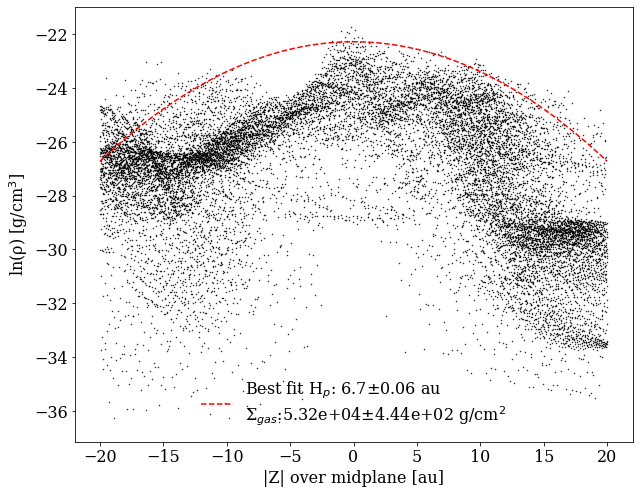

In [6]:
x = np.linspace(-2*radius * cgs_length, 2*radius * cgs_length, 1000)
y = fit_scaleheight(x, *fit_params)
fig, axs = plt.subplots(figsize = (10, 8))

axs.scatter(heights, np.log(densities), marker='.', s = 0.8, color = 'black')
axs.plot(x, y, ls = '--', color = 'red', label = f'Best fit H$_p$: {fit_params[1]:1.2}$\pm${fit_err[1]:1.2f} au'+'\nΣ$_{gas}$:'+f'{fit_params[0] * sn.cgs.au:1.2e}$\pm${fit_err[0] * sn.cgs.au:1.2e} g/cm$^2$')
axs.set(xlabel = '|Z| over midplane [au]', ylabel = 'ln(ρ) [g/cm$^3$]')
axs.legend(frameon = False)

## Trying to keep the Gaussian shape of the function and introducing the weights being the density

In [7]:
def fit_scaleheight(x, Σ, H):
    return Σ / (np.sqrt(2 * np.pi) * H) * np.exp( - x**2 / (2 * H**2)) 

model = Model(fit_scaleheight)
params = model.make_params(Σ = 1e4, H = 5.0)
result = model.fit(densities, x = heights, params = params)#, weights = densities)
fit_params = np.array(list(result.best_values.values()))
fit_err = np.array([par.stderr for _, par in result.params.items()])
result

In [8]:
for parnname, par in result.params.items():
    #par_err = par.stderr; par_val = par.value
    print(parnname, par.value, par.stderr)

Σ 5.015114927163732e-10 5.13358020400571e-12
H 5.306104845725849 0.05648977146744539


In [9]:
fit_params[0] / sn.cgs.au

3.3523495502431365e-23

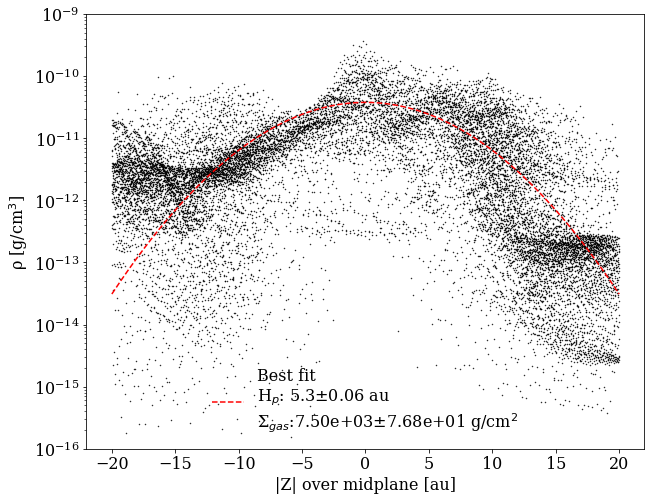

In [10]:
x = np.linspace(-2*radius * cgs_length, 2*radius * cgs_length, 1000)
y = fit_scaleheight(x, *fit_params)

fig, axs = plt.subplots(figsize = (10, 8))

axs.semilogy(x, y, ls = '--', color = 'red', label = f'Best fit\nH$_p$: {fit_params[1]:1.2}$\pm${fit_err[1]:1.2f} au'+'\nΣ$_{gas}$:'+f'{fit_params[0] * sn.cgs.au:1.2e}$\pm${fit_err[0] * sn.cgs.au:1.2e} g/cm$^2$')
axs.scatter(heights, densities, marker='.', s = 0.8, color = 'black')

axs.set(xlabel = '|Z| over midplane [au]', ylabel = 'ρ [g/cm$^3$]', ylim = (1e-16, 1e-9))
axs.legend(frameon = False)

### Calculating the surface densitty $\Sigma_{gas}$ from the scale height
#### $$\Sigma_{gas} = \int_{-H}^{+H} \rho dz $$

In [11]:
sum_dens = 0
for p in sn.patches:
    r = p.position - star_pos
    z_new = np.dot(r, e_z)
    r_new = r - z_new * e_z
    H_p = fit_params[1] / cgs_length
    if abs(z_new) <= 2*radius and np.linalg.norm(r_new) < radius + Δ_radius and np.linalg.norm(r_new) > radius - Δ_radius:

        e_r = r_new / np.linalg.norm(r_new)
        e_θ = np.cross(e_z, e_r)

        XX, YY, ZZ = np.meshgrid(p.xi - star_pos[0], p.yi - star_pos[1], p.zi - star_pos[2], indexing='ij')
        p_r = np.array([XX, YY, ZZ]); 
        p_newz = np.sum(e_z[:, None, None, None] * p_r, axis = 0)   # z-coordinate in new axis (Cylindrical)

        if (abs(p_newz) > H_p).all(): continue
        idx = np.nonzero(abs(p_newz) < H_p)
        sum_dens += np.sum(p.var('d')[idx] * np.prod(p.ds))


annulus_vol = np.pi*((radius + Δ_radius)**2 - (radius -  Δ_radius)**2) * H_p
annulus_vol *= sn.scaling.l**3 # Volumne of annulus in cm^3

mass_annulus = sum_dens * sn.scaling.m
print(mass_annulus)
Σ_gas = mass_annulus / (np.pi*((radius + Δ_radius)**2 - (radius -  Δ_radius)**2) * sn.scaling.l**2)
Σ_gas

2.558321576496508e+30


90.9666251085939

In [12]:
sum_dens = 0
sum_vol = 0
for p in sn.patches:
    r = p.position - star_pos
    z_new = np.dot(r, e_z)
    r_new = r - z_new * e_z
    H_p = fit_params[1] / cgs_length
    if abs(z_new) <= 2*radius and np.linalg.norm(r_new) < radius + Δ_radius and np.linalg.norm(r_new) > radius - Δ_radius:

        e_r = r_new / np.linalg.norm(r_new)
        e_θ = np.cross(e_z, e_r)

        XX, YY, ZZ = np.meshgrid(p.xi - star_pos[0], p.yi - star_pos[1], p.zi - star_pos[2], indexing='ij')
        p_r = np.array([XX, YY, ZZ]); 
        p_newz = np.sum(e_z[:, None, None, None] * p_r, axis = 0)   # z-coordinate in new axis (Cylindrical)

        if (abs(p_newz) > H_p).all(): continue
        idx = np.nonzero(abs(p_newz) < H_p)
        sum_vol += np.prod(p.ds)
        sum_dens += np.sum(p.var('d')[idx] * np.prod(p.ds))


annulus_vol = np.pi*((radius + Δ_radius)**2 - (radius -  Δ_radius)**2) * H_p
#annulus_vol *= sn.scaling.l**3 # Volumne of annulus in cm^3

mass_annulus = sum_dens / sum_vol * annulus_vol * sn.scaling.m
print(mass_annulus), print(mass_annulus / annulus_vol)
Σ_gas = mass_annulus / (np.pi*((radius + Δ_radius)**2 - (radius -  Δ_radius)**2) * sn.scaling.l**2)
Σ_gas

4.3760030806503685e+31
3.6869299515531435e+46


1555.9819976060676

# Making loop over different radii

In [13]:
eval_R = np.arange(10, 34, 2)
eval_R.shape

(12,)

mass 4.267812498959245e-07
vol 1.625158341234112e-13
Total mass [g] 3.7368200167801276e+28
mass 1.2436492013989664e-07
vol 2.840956636607217e-14
Total mass [g] 7.044102360270507e+28
mass 4.236218131836722e-08
vol 8.526512829121202e-14
Total mass [g] 1.5368571986947485e+29
mass 1.8111783095520195e-07
vol 9.178595383740884e-14
Total mass [g] 5.8855124370088894e+28
mass 6.204751312743895e-08
vol 2.7085104992163878e-14
Total mass [g] 8.31268122682216e+28
mass 9.17441269621122e-08
vol 6.030592691885772e-14
Total mass [g] 6.891663359395854e+28
mass 2.62042578885735e-08
vol 1.7670760688037745e-14
Total mass [g] 8.407220603338248e+28
mass 6.17402782915864e-08
vol 4.0353137498172487e-14
Total mass [g] 1.1823958210380695e+29
mass 1.2295192298571872e-07
vol 1.116398640199634e-13
Total mass [g] 7.43983209401771e+28
mass 1.2742377769603408e-07
vol 1.0309201409208768e-13
Total mass [g] 9.222260889921379e+28
mass 9.214675966858453e-08
vol 6.951991066150853e-14
Total mass [g] 1.1115696419209313e+29
ma

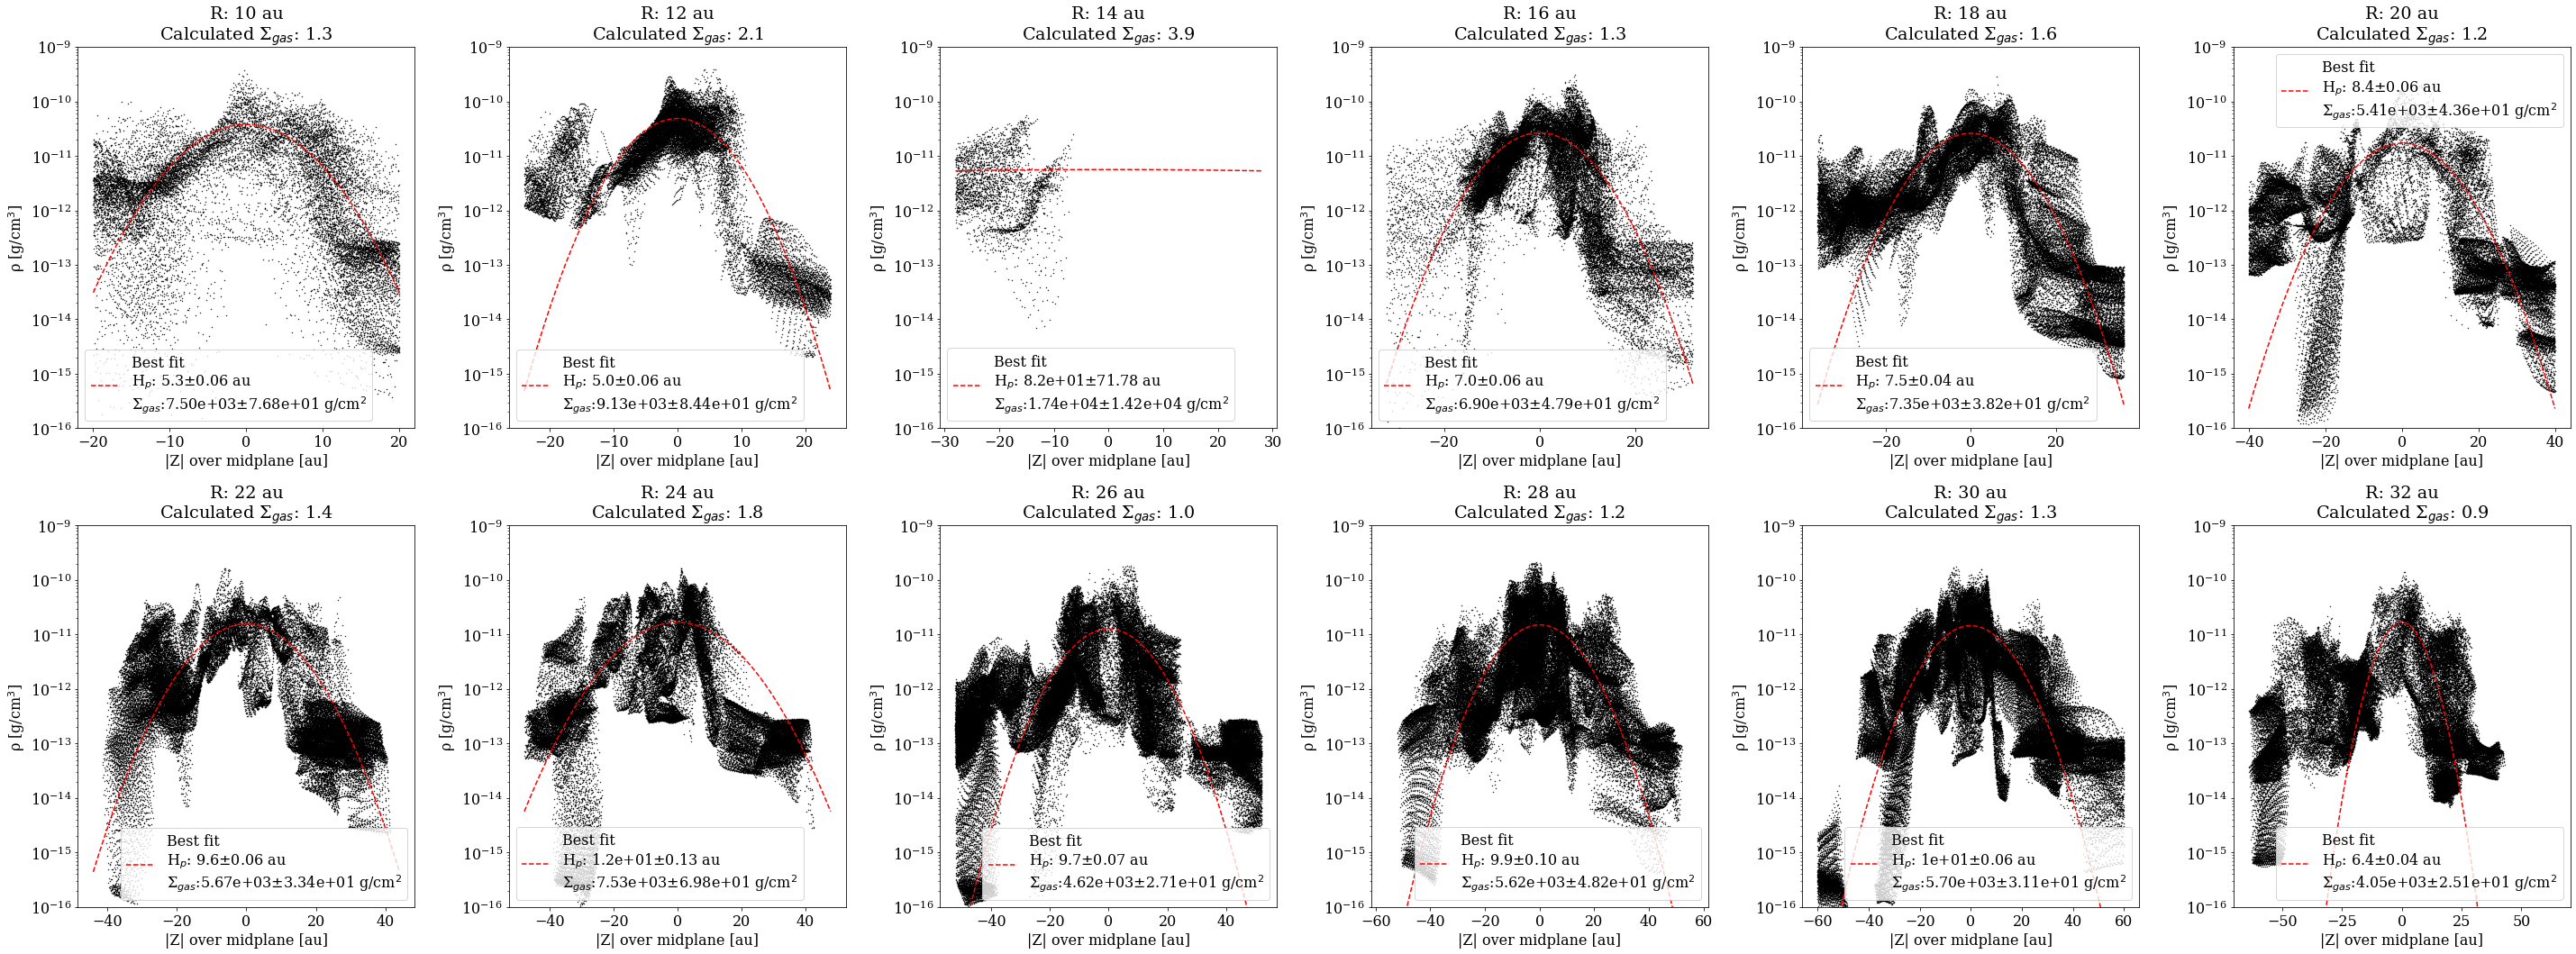

In [14]:
fig, ax = plt.subplots(2, 6, figsize = (40, 15))
for R_an, axs in zip(eval_R, ax.flatten()):
    densities = []
    heights = []
    for p in sn.patches:
        r = p.position - star_pos
        z_new = np.dot(r, e_z)
        r_new = r - z_new * e_z
        radius = R_an / cgs_length
        Δ_radius = 1 / cgs_length
        if abs(z_new) <= 2*radius and np.linalg.norm(r_new) < radius + Δ_radius and np.linalg.norm(r_new) > radius - Δ_radius:

            e_r = r_new / np.linalg.norm(r_new)
            e_θ = np.cross(e_z, e_r)

            XX, YY, ZZ = np.meshgrid(p.xi - star_pos[0], p.yi - star_pos[1], p.zi - star_pos[2], indexing='ij')
            p_r = np.array([XX, YY, ZZ]);
            p_newz = np.sum(e_z[:, None, None, None] * p_r, axis = 0)   # z-coordinate in new axis (Cylindrical)

            if (abs(p_newz) > 2*radius).all(): continue
            idx = np.nonzero(abs(p_newz) < 2*radius)
            densities.extend(p.var('d')[idx].flatten())
            heights.extend(p_newz[idx].flatten())

    densities = np.asarray(densities) * cgs_density
    heights = np.asarray(heights) * sn.scaling.l / sn.cgs.au


    def fit_scaleheight(x, Σ, H):
        return Σ / (np.sqrt(2 * np.pi) * H) * np.exp( - x**2 / (2 * H**2)) 

    model = Model(fit_scaleheight)
    params = model.make_params(Σ = 1e4, H = 5.0)
    result = model.fit(densities, x = heights, params = params)#, weights = densities)
    fit_params = np.array(list(result.best_values.values()))
    fit_err = np.array([par.stderr for _, par in result.params.items()])

    sum_dens = 0
    sum_vol = 0
    for p in sn.patches:
        r = p.position - star_pos
        z_new = np.dot(r, e_z)
        r_new = r - z_new * e_z
        H_p = fit_params[1] / cgs_length
        if abs(z_new) <= 2*radius and np.linalg.norm(r_new) < radius + Δ_radius and np.linalg.norm(r_new) > radius - Δ_radius:

            e_r = r_new / np.linalg.norm(r_new)
            e_θ = np.cross(e_z, e_r)

            XX, YY, ZZ = np.meshgrid(p.xi - star_pos[0], p.yi - star_pos[1], p.zi - star_pos[2], indexing='ij')
            p_r = np.array([XX, YY, ZZ]); 
            p_newz = np.sum(e_z[:, None, None, None] * p_r, axis = 0)   # z-coordinate in new axis (Cylindrical)

            if (abs(p_newz) > H_p).all(): continue
            idx = np.nonzero(abs(p_newz) < H_p)
            sum_vol += np.prod(p.ds) * len(np.asarray(idx).flatten()) # This is where the mistake was from since last time
            sum_dens += np.sum(p.var('d')[idx] * np.prod(p.ds))
    print('mass', sum_dens)
    print('vol', sum_vol)



    annulus_vol = np.pi*((radius + Δ_radius)**2 - (radius -  Δ_radius)**2) * 2*H_p
    #annulus_vol *= sn.scaling.l**3 # Volumne of annulus in cm^3

    mass_annulus = sum_dens / sum_vol * annulus_vol * sn.scaling.m
    Σ_gas = mass_annulus / (np.pi*((radius + Δ_radius)**2 - (radius -  Δ_radius)**2) * sn.scaling.l**2)
    Σ_gas
    print('Total mass [g]', mass_annulus)

    x = np.linspace(-2*radius * cgs_length, 2*radius * cgs_length, 1000)
    y = fit_scaleheight(x, *fit_params)

    axs.semilogy(x, y, ls = '--', color = 'red', label = f'Best fit\nH$_p$: {fit_params[1]:1.2}$\pm${fit_err[1]:1.2f} au'+'\nΣ$_{gas}$:'+f'{fit_params[0] * sn.cgs.au:1.2e}$\pm${fit_err[0] * sn.cgs.au:1.2e} g/cm$^2$')
    axs.scatter(heights, densities, marker='.', s = 0.8, color = 'black')

    axs.set(xlabel = '|Z| over midplane [au]', ylabel = 'ρ [g/cm$^3$]', ylim = (1e-16, 1e-9), title = f'R: {R_an} au'+'\nCalculated Σ$_{gas}$:' + f'{Σ_gas:4.1f}')
    axs.legend()
plt.tight_layout()